In [4]:
import pandas as pd
import numpy as np

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

In [25]:
df = pd.read_csv('/Users/mr.tian/Desktop/used_cars.csv')

In [26]:
df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type'].mode()[0])
df['accident'] = df['accident'].fillna('Unknown')
df['clean_title'] = df['clean_title'].fillna('Unknown')

In [27]:
df['milage'] = (df['milage'].str.replace(',', '').str.extract(r'(\d+)').astype(float))
df['price'] = (df['price'].str.replace('$', '').str.replace(',', '').astype(float))

In [28]:
df['car_age'] = 2025 - df['model_year']

In [29]:
df = pd.get_dummies(df, columns=['fuel_type', 'clean_title'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['accident'], prefix='accident', drop_first=True, dtype=int)

In [30]:
def topk_onehot(df, col, k, prefix=None):
    top_k = df[col].value_counts().nlargest(k).index

    clean_col = col + '_clean'
    df[clean_col] = df[col].where(df[col].isin(top_k), 'Other')

    df = pd.get_dummies(df, columns=[clean_col], prefix=prefix or col, drop_first=True, dtype=int)

    return df

In [31]:
df = topk_onehot(df, col='model', k=20, prefix='model')
df = topk_onehot(df, col='ext_col', k=10)
df = topk_onehot(df, col='int_col', k=10)
df = topk_onehot(df, col='brand', k=10, prefix='brand')

In [32]:
s = df['transmission'].astype(str).str.lower()

df['trans_simple'] = 'Other'

df.loc[s.str.contains('cvt'), 'trans_simple'] = 'CVT'
df.loc[s.str.contains('manual|m/t'), 'trans_simple'] = 'Manual'
df.loc[s.str.contains('auto|a/t'), 'trans_simple'] = 'Automatic'

df = pd.get_dummies(df, columns=['trans_simple'], drop_first=True, dtype=int)

In [33]:
e = df['engine'].astype(str).str.lower()
df['engine_l'] = e.str.extract(r'(\d\.\d)\s*l').astype(float)
df['engine_cyl'] = e.str.extract(r'([vi]\d+)')
df = pd.get_dummies(df, columns=['engine_cyl'], drop_first=True, dtype=int)

In [34]:
df.drop(columns=['ext_col', 'int_col'], axis=1, inplace=True)
df.drop(columns=['transmission'], axis=1, inplace=True)
df.drop(columns=['brand'], axis=1, inplace=True)
df.drop(columns=['engine', 'engine_l'], axis=1, inplace=True)
df.drop(columns=['model'], axis=1, inplace=True)

In [86]:
df['price'] = np.log1p(df['price'])

In [87]:
df['milage'] = np.log1p(df['milage'])

In [88]:
p1, p99 = df['price'].quantile([0.01, 0.99])
df = df[(df['price'] >= p1) & (df['price'] <= p99)]

In [89]:
X = df.drop(columns='price', axis=1)
y = df['price']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
pred = rf.predict(X_test_scaled)
print('R2:', r2_score(y_test, pred))

R2: 0.6721996630925138


In [93]:
scores = cross_val_score(
    rf,
    X,
    y,
    cv=5,
    scoring='r2'
)
print(scores)

[0.63288469 0.67248559 0.64051532 0.6919257  0.67157128]


In [94]:
importances = rf.feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

print(feat_imp.head(20))

milage                    0.534198
model_year                0.119788
car_age                   0.092224
brand_Porsche             0.026072
brand_Other               0.020467
engine_cyl_v6             0.012761
accident_None reported    0.010392
int_col_Black             0.009949
engine_cyl_i4             0.009332
ext_col_Black             0.008913
brand_Mercedes-Benz       0.008838
fuel_type_Gasoline        0.008344
int_col_Gray              0.008221
ext_col_White             0.007867
trans_simple_Other        0.007179
ext_col_Gray              0.006222
ext_col_Silver            0.005953
trans_simple_Manual       0.005436
brand_Ford                0.005001
model_Other               0.004970
dtype: float64


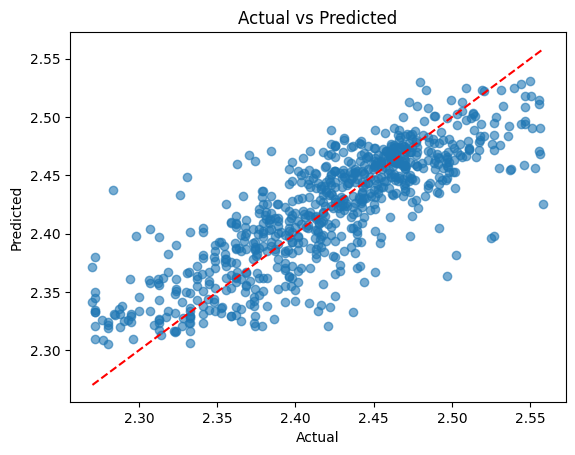

In [103]:
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test_scaled)

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.savefig("/Users/mr.tian/Desktop/pred_vs_actual.png",
            dpi=300, bbox_inches="tight")
plt.show()

In [102]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(xgb, X, y, cv=5, scoring='r2')
scores.mean(), scores.std()

(np.float64(0.7042533869808187), np.float64(0.025417979788073322))